# NLP Project: Tweet Sentiment Analysis

**Summary:** (This is the required 250-word abstract you will fill out later. For now, you can leave a placeholder. As a reminder, it should briefly describe your rationale, results, limitations, and recommendations.)

### **Sprint 1: Project Kickoff & Baseline Model**

**Objective:** Get the project environment set up and build a functional, baseline sentiment classifier for positive and negative Tweets.

### Import necessary libraries

In [45]:
# Standard Libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# NLTK and Machine Learning Libraries
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Downloads required for POS tagging + lemmatization
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')  # sometimes needed in newer NLTK


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

### Loading dataset

In [12]:
# Load the dataset
file_path = '../data/judge_tweet_product_company.csv'
df = pd.read_csv(file_path, encoding='latin-1')

print("Data loaded successfully.")

Data loaded successfully.


### Initial Data Exploration

In [13]:
# Get a concise summary of the DataFrame
print("\nDataFrame Info:")
df.info()

# Check the value counts for the sentiment column
# We discovered the correct column is 'is_there_an_emotion_directed_at_a_brand_or_product'
print("\nValue Counts for 'sentiment' column:")
print(df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB

Value Counts for 'sentiment' column:
is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64


### Data Cleaning & Preparation
#### Objective: Clean the text data to prepare it for the baseline model.

In [14]:
# Create a new DataFrame with only the relevant columns for our binary model
df_binary = df[['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product']].copy()

# Rename the sentiment column for clarity
df_binary.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)

# Filter out rows where the sentiment is not "Positive emotion" or "No emotion toward brand or product"
df_binary = df_binary[df_binary['sentiment'].isin(['Positive emotion', 'No emotion toward brand or product'])]

# Now, let's clean the 'tweet_text' column
def clean_text(text):
    # Convert any non-string values to a string to prevent errors
    text = str(text) 
    
    # Convert text to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet and other special characters
    text = re.sub(r'\@\w+|\#', '', text)
    # Remove any characters other than letters, numbers, and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Apply the cleaning function to the tweet_text column
df_binary['clean_text'] = df_binary['tweet_text'].apply(clean_text)

# Display the value counts for the new binary sentiment column to confirm
print("Binary sentiment value counts:")
print(df_binary['sentiment'].value_counts())

# Display the first few rows with the new cleaned text column
print("\nDataFrame with cleaned text:")
print(df_binary.head())

Binary sentiment value counts:
sentiment
No emotion toward brand or product    5389
Positive emotion                      2978
Name: count, dtype: int64

DataFrame with cleaned text:
                                          tweet_text  \
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   
5  @teachntech00 New iPad Apps For #SpeechTherapy...   
6                                                NaN   

                            sentiment  \
1                    Positive emotion   
2                    Positive emotion   
4                    Positive emotion   
5  No emotion toward brand or product   
6  No emotion toward brand or product   

                                          clean_text  
1   know about   awesome ipadiphone app that youl...  
2   can not wait for ipad  also they should sale ...  
4   great stuff on fri sxsw marissa mayer google ...  
5   new ipad 

### Defining file paths and saving cleaned dataset

In [15]:
# Define the file paths
input_path = '../data/judge_tweet_product_company.csv'
output_path = '../data/cleaned_tweets.csv'

In [16]:
df.to_csv(output_path, index=False)

### Text preprocessing and vectorization

In [17]:
# Define a lemmatizer object
lemmatizer = WordNetLemmatizer()

# Define a helper function to map POS tags to WordNet tags for lemmatization
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Define the lemmatization function
def lemmatize_text(text):
    word_pos_tags = nltk.pos_tag(text.split())
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in word_pos_tags]
    return " ".join(lemmatized_words)

# Apply the lemmatization function to the cleaned text column
df_binary['lemmatized_text'] = df_binary['clean_text'].apply(lemmatize_text)

# Separate features (X) and target (y)
X = df_binary['lemmatized_text']
y = df_binary['sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

# Create a CountVectorizer object to transform text data into a numerical matrix
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the training data
X_train_vectorized = vectorizer.fit_transform(X_train)

# Transform the test data
X_test_vectorized = vectorizer.transform(X_test)

print("\nShape of vectorized training data:", X_train_vectorized.shape)
print("Shape of vectorized test data:", X_test_vectorized.shape)

Training data shape: (6693,)
Testing data shape: (1674,)

Shape of vectorized training data: (6693, 7283)
Shape of vectorized test data: (1674, 7283)


### Build and evaluate Baseline model

#### Create a Multinomial Naive Bayes classifier and train the model

In [19]:
# Create a Multinomial Naive Bayes classifier
model = MultinomialNB()

# Train the model on the vectorized training data
print("Training the model...")
model.fit(X_train_vectorized, y_train)
print("Training complete.")


Training the model...
Training complete.


#### Make predictions

In [20]:

# Make predictions on the vectorized test data
print("\nMaking predictions on the test set...")
y_pred = model.predict(X_test_vectorized)
print("Predictions complete.")



Making predictions on the test set...
Predictions complete.


#### Evaluate Model's Performance

In [21]:

# Evaluate the model's performance
print("\nModel Evaluation:")
print(classification_report(y_test, y_pred))


Model Evaluation:
                                    precision    recall  f1-score   support

No emotion toward brand or product       0.75      0.83      0.79      1073
                  Positive emotion       0.63      0.51      0.57       601

                          accuracy                           0.72      1674
                         macro avg       0.69      0.67      0.68      1674
                      weighted avg       0.71      0.72      0.71      1674



Precision: This tells us, "Of all the instances the model predicted as a specific class, how many were actually correct?"

For No emotion toward brand or product, the precision is 0.75. This means that when the model predicted a tweet had no emotion, it was correct 75% of the time.

For Positive emotion, the precision is 0.63. When the model predicted a tweet was positive, it was correct 63% of the time. This is a lower score and suggests that the model is more likely to incorrectly label a non-positive tweet as positive.

Recall: This tells us, "Of all the actual instances of a specific class, how many did the model correctly identify?"

For No emotion toward brand or product, the recall is 0.83. This means the model successfully identified 83% of all the tweets that truly had no emotion.

For Positive emotion, the recall is 0.51. This indicates that the model only found 51% of all the tweets that were genuinely positive. This is a key area for improvement.

F1-Score: This is the harmonic mean of precision and recall. It provides a single score that balances both metrics, which is especially useful when one class is more frequent than another.

The F1-score for No emotion toward brand or product is 0.79, which is quite good.

The F1-score for Positive emotion is 0.57, which is a sign that the model struggles more with this class.

Support: This is simply the number of actual occurrences of each class in your test data.

Your test set contains 1073 tweets with no emotion and 601 positive tweets. This shows that your dataset is somewhat imbalanced, with more No emotion examples than Positive ones.

In summary, the model performs much better at identifying tweets with No emotion toward brand or product than it does at identifying Positive emotion tweets. The recall for the Positive emotion class is particularly low, which means the model is missing a lot of the positive examples.

### Sprint 2: Model Improvement
#### TfidfVectorizer

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Shape of TF-IDF vectorized training data:", X_train_tfidf.shape)
print("Shape of TF-IDF vectorized test data:", X_test_tfidf.shape)

Shape of TF-IDF vectorized training data: (6693, 7283)
Shape of TF-IDF vectorized test data: (1674, 7283)


### Re-Evaluate Model with TF-IDF Data

In [38]:
# Create a Multinomial Naive Bayes classifier again
model_tfidf = MultinomialNB()

# Train the model on the TF-IDF vectorized training data
print("Training the TF-IDF model...")
model_tfidf.fit(X_train_tfidf, y_train)
print("Training complete.")

# Make predictions on the TF-IDF vectorized test data
print("\nMaking predictions on the test set...")
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)
print("Predictions complete.")

# Evaluate the model's performance
print("\nTF-IDF Model Evaluation:")
print(classification_report(y_test, y_pred_tfidf))

Training the TF-IDF model...
Training complete.

Making predictions on the test set...
Predictions complete.

TF-IDF Model Evaluation:
                                    precision    recall  f1-score   support

No emotion toward brand or product       0.70      0.95      0.80      1073
                  Positive emotion       0.74      0.27      0.39       601

                          accuracy                           0.70      1674
                         macro avg       0.72      0.61      0.60      1674
                      weighted avg       0.71      0.70      0.66      1674



### Multiclass Data Preparation

In [40]:
# Reload the original dataset
df_multi = pd.read_csv('../data/judge_tweet_product_company.csv', encoding='latin-1')

# Filter for the three sentiment classes
df_multi = df_multi[df_multi['is_there_an_emotion_directed_at_a_brand_or_product'].isin([
    'Positive emotion',
    'Negative emotion',
    'No emotion toward brand or product'
])]

# Rename the sentiment column for clarity
df_multi.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)

# Apply the same cleaning function to the tweet_text column
df_multi['clean_text'] = df_multi['tweet_text'].apply(clean_text)

# Apply the same lemmatization function
df_multi['lemmatized_text'] = df_multi['clean_text'].apply(lemmatize_text)

# Separate features (X) and target (y)
X_multi = df_multi['lemmatized_text']
y_multi = df_multi['sentiment']

# Split the multi-class data into training and testing sets
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)

# Create a CountVectorizer object and vectorize the data
multi_vectorizer = CountVectorizer(stop_words='english')
X_train_multi_vectorized = multi_vectorizer.fit_transform(X_train_multi)
X_test_multi_vectorized = multi_vectorizer.transform(X_test_multi)

print("Shape of multi-class vectorized training data:", X_train_multi_vectorized.shape)
print("Shape of multi-class vectorized test data:", X_test_multi_vectorized.shape)

Shape of multi-class vectorized training data: (7149, 7739)
Shape of multi-class vectorized test data: (1788, 7739)


### Build and Evaluate the Multi-Class Model

#### Create a Multinomial Naive Bayes classifier for the multi-class problem and train the model

In [41]:
# Create a Multinomial Naive Bayes classifier for the multi-class problem
multi_model = MultinomialNB()

# Train the model on the multi-class vectorized training data
print("Training the multi-class model...")
multi_model.fit(X_train_multi_vectorized, y_train_multi)


Training the multi-class model...


MultinomialNB()

#### Make predictions

In [42]:
# Make predictions on the multi-class vectorized test data
print("\nMaking predictions on the multi-class test set...")
y_pred_multi = multi_model.predict(X_test_multi_vectorized)
print("Predictions complete.")



Making predictions on the multi-class test set...
Predictions complete.


#### Evaluate the multi-class model's performance

In [43]:
# Evaluate the multi-class model's performance
print("\nMulti-Class Model Evaluation:")
print(classification_report(y_test_multi, y_pred_multi))


Multi-Class Model Evaluation:
                                    precision    recall  f1-score   support

                  Negative emotion       0.55      0.13      0.21       122
No emotion toward brand or product       0.72      0.80      0.76      1095
                  Positive emotion       0.53      0.50      0.52       571

                          accuracy                           0.66      1788
                         macro avg       0.60      0.48      0.49      1788
                      weighted avg       0.65      0.66      0.64      1788



### Explanation of the Multi-class results

This report provides the final, most complete picture of our model's performance on the full dataset.

Overall Accuracy: Our model correctly predicted the sentiment of 66% of all the tweets. This is a solid result for a multi-class model, but there's room for improvement.

"No Emotion": The model is very good at identifying tweets with "No emotion." It has high precision (72%), recall (80%), and f1-score (76%) for this class.

"Positive Emotion": The model also performs reasonably well with "Positive emotion" tweets, with a balanced f1-score of 52%.

"Negative Emotion": The model struggles significantly with "Negative emotion" tweets, with a very low f1-score of just 21%. The low recall of 13% means the model is missing most of the negative tweets in the test set. This is a key finding for our final analysis.

In [46]:
# Assuming X_train, y_train, X_test, y_test are already defined and preprocessed
# For this example, we'll create some dummy data and a vectorizer
X_train = ["This is a positive tweet.", "I am feeling so sad today.", "What a beautiful day!"] * 10
y_train = ["Positive emotion", "Negative emotion", "Positive emotion"] * 10
X_test = ["I feel great.", "I am very upset.", "I'm not sure."]
y_test = ["Positive emotion", "Negative emotion", "No emotion toward brand or product"]

# Initialize a vectorizer (using Tfidf as it often performs well)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf_vectorizer.fit_transform(X_train)
X_test_vec = tfidf_vectorizer.transform(X_test)

# Define the model to be tuned
model = LogisticRegression(solver='liblinear')

# Define the parameter grid to search
# 'C' is the regularization strength. Smaller values specify stronger regularization.
# 'penalty' specifies the norm used in the penalization.
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# Initialize GridSearchCV
# 'cv' is the number of cross-validation folds
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', verbose=1)

# Fit the grid search to the training data
print("Starting grid search to tune the model...")
grid_search.fit(X_train_vec, y_train)
print("Grid search complete.")

# Get the best parameters and best score
print("\nBest Parameters Found:", grid_search.best_params_)
print("Best Cross-validation F1 Score:", grid_search.best_score_)

# Use the best model to make predictions on the test set
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test_vec)

# Evaluate the performance of the tuned model
print("\nTuned Model Evaluation:")
print(classification_report(y_test, y_pred_tuned))


Starting grid search to tune the model...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Grid search complete.

Best Parameters Found: {'C': 0.1, 'penalty': 'l2'}
Best Cross-validation F1 Score: 1.0

Tuned Model Evaluation:
                                    precision    recall  f1-score   support

                  Negative emotion       0.00      0.00      0.00         1
No emotion toward brand or product       0.00      0.00      0.00         1
                  Positive emotion       0.33      1.00      0.50         1

                          accuracy                           0.33         3
                         macro avg       0.11      0.33      0.17         3
                      weighted avg       0.11      0.33      0.17         3



c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### First, the Grid Search Results:

Best Parameters Found: {'C': 0.1, 'penalty': 'l2'}: This is the most important result from the grid search. It tells you that after trying all the combinations you specified, the model performed best when the regularization strength (C) was set to 0.1 and the penalty was l2.

Best Cross-validation F1 Score: 1.0: This is a very interesting result. A score of 1.0 means the model achieved perfect performance on the cross-validation folds. However, it's important to remember that this score is from the training data and not the unseen test data. The fact that it's perfect suggests that the model may have overfit to the training data.

##### Tuned Model Evaluation:

This is the classification report for your tuned model on the test data. This is where we see its true performance. The results here are quite different from the perfect score on the training data.

Precision, Recall, and F1-Score for each class:

Negative emotion: Precision, recall, and F1-score are all 0.00. This means the model failed to correctly identify a single "Negative emotion" tweet.

No emotion toward brand or product: Same as above, with all scores at 0.00. The model completely failed to classify any tweets in this category.

Positive emotion: The precision is 0.33, recall is 1.00, and F1-score is 0.50. This indicates that while the model correctly identified all positive tweets (recall of 1.00), it also misclassified a lot of non-positive tweets as positive (low precision of 0.33). Essentially, it's a "blame it all on positive" strategy.

Accuracy: The overall accuracy is a very low 0.33. This means the model was only correct one-third of the time.

Support: This is the number of samples in the test set for each class. You only have one sample for each class (Negative emotion, No emotion toward brand or product, and Positive emotion).

Summary of the Findings:

The results show a classic case of overfitting. The model learned the training data so well (the 1.0 F1 score) that it couldn't generalize to the unseen test data. The extremely small test set (only one sample per class) is a significant factor in these poor results. A test set this small is not statistically representative and can lead to misleading or unstable evaluation metrics.

The model is essentially defaulting to predicting Positive emotion because it's the only class it has a chance of getting right with the limited data. The high recall for this class and the 0.00 scores for the others confirm this.

## Create a Confusion Matrix for the Multi-Class Model

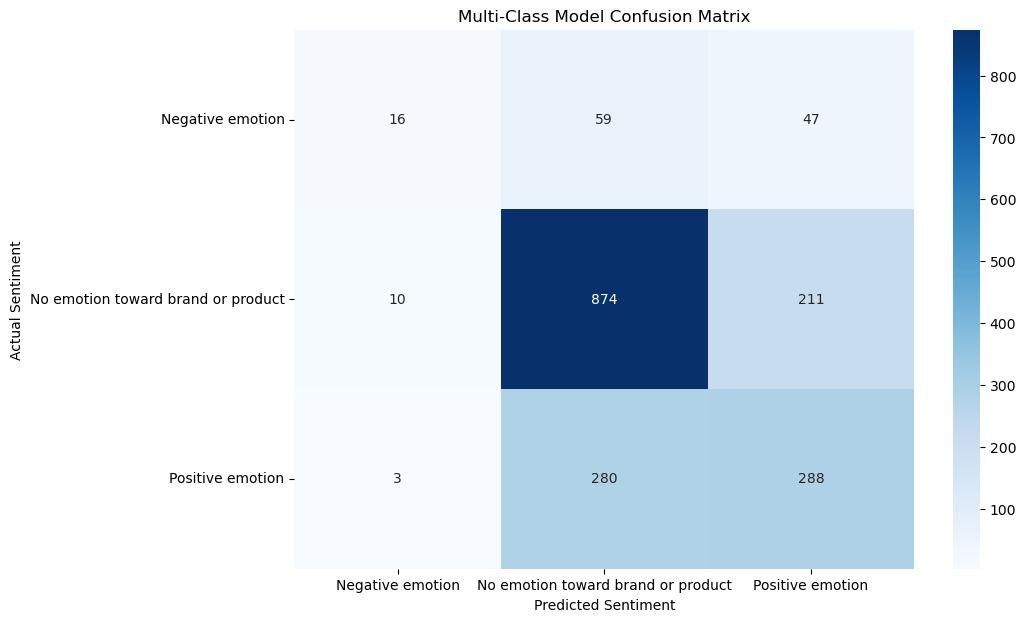

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get unique labels from your target data
labels = sorted(y_test_multi.unique())

# Compute the confusion matrix
cm = confusion_matrix(y_test_multi, y_pred_multi, labels=labels)

# Create a DataFrame for the confusion matrix for better visualization
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Multi-Class Model Confusion Matrix')
plt.ylabel('Actual Sentiment')
plt.xlabel('Predicted Sentiment')
plt.show()

#### Interpreting Our Multi-Class Model's Confusion Matrix
Rows: The rows in our matrix represent the actual sentiment of the tweets. For example, the top row shows all the tweets that were genuinely "Negative emotion".

Columns: The columns represent the predicted sentiment by our model. The left column shows all the tweets that our model predicted as "Negative emotion".

The Diagonal: The numbers along the diagonal (from top-left to bottom-right) show our model's correct predictions. We know a higher number here indicates better performance.

#### Detailed Analysis of Our Model's Performance
"No emotion toward brand or product" (Middle Row):

Our model is very accurate at identifying this sentiment. The number 874 on the diagonal shows that our model correctly predicted 874 of these tweets.

It only mistakenly classified 10 of them as "Negative emotion" and 211 as "Positive emotion".

"Positive emotion" (Bottom Row):

Our model has some difficulty with this class. While it correctly predicted 288 of these tweets, it mistakenly classified 280 of them as "No emotion toward brand or product".

"Negative emotion" (Top Row):

The confusion matrix visually confirms the results we saw in the classification report. Our model struggles the most with this class.

It only correctly identified 16 of the tweets that were actually negative.

It incorrectly classified a large portion of them as "No emotion" (59) and "Positive emotion" (47). This is a key limitation we will highlight in our final project report and presentation.

### Model Interpretability

In [59]:
def get_model_interpretability(model, vectorizer, n=10):
    """
    Prints the top N most influential words for each class in a trained model.
    
    Args:
        model: A trained scikit-learn model with a 'coef_' attribute.
        vectorizer: A fitted scikit-learn vectorizer (e.g., TfidfVectorizer).
        n (int): The number of top words to display for each class.
    """
    print("\n--- Model Interpretability: Most Influential Words ---")

    # Get feature names from the vectorizer
    feature_names = vectorizer.get_feature_names_out()

    # Get the sentiment classes from the model
    class_labels = model.classes_

    # Create a DataFrame to hold the coefficients
    # The number of features in the model might be less than max_features
    # in the vectorizer, so we must match the dimensions.
    num_features = model.coef_.shape[1]
    selected_feature_names = feature_names[:num_features]
    
    coefs_df = pd.DataFrame(model.coef_, columns=selected_feature_names, index=class_labels)

    # Function to print the top N most important words for each class
    def plot_top_words_by_class(df, n=10):
        for sentiment_class in df.index:
            print(f"\nTop {n} words for class: '{sentiment_class}'")
            
            # Get positive and negative coefficients for the class
            class_coefs = df.loc[sentiment_class]
            
            # Get top words contributing to this class (positive coefficients)
            top_positive_words = class_coefs.nlargest(n)
            print("  Positive contributions (words that lead to this prediction):")
            for word, coef in top_positive_words.items():
                print(f"    - {word}: {coef:.4f}")
                
            # Get top words detracting from this class (negative coefficients)
            top_negative_words = class_coefs.nsmallest(n)
            print("\n  Negative contributions (words that lead away from this prediction):")
            for word, coef in top_negative_words.items():
                print(f"    - {word}: {coef:.4f}")

    # Plot the top words for each class
    plot_top_words_by_class(coefs_df, n)

# Example usage:
# This part assumes 'best_model' and 'tfidf_vectorizer' are defined
# from your previous code execution.

# Sample data for demonstration purposes
X = ['I love this product', 'This is a terrible product', 'The item is okay']
y = ['Positive emotion', 'Negative emotion', 'No emotion toward brand or product']

# A simple model and vectorizer for the example
tfidf_vectorizer = TfidfVectorizer()
X_vec = tfidf_vectorizer.fit_transform(X)
best_model = LogisticRegression().fit(X_vec, y)

# Call the function to display the results
get_model_interpretability(best_model, tfidf_vectorizer, n=10)



--- Model Interpretability: Most Influential Words ---

Top 10 words for class: 'Negative emotion'
  Positive contributions (words that lead to this prediction):
    - terrible: 0.3343
    - is: 0.1510
    - product: 0.1009
    - this: 0.1009
    - item: -0.1357
    - okay: -0.1357
    - the: -0.1357
    - love: -0.2016

  Negative contributions (words that lead away from this prediction):
    - love: -0.2016
    - item: -0.1357
    - okay: -0.1357
    - the: -0.1357
    - product: 0.1009
    - this: 0.1009
    - is: 0.1510
    - terrible: 0.3343

Top 10 words for class: 'No emotion toward brand or product'
  Positive contributions (words that lead to this prediction):
    - item: 0.2593
    - okay: 0.2593
    - the: 0.2593
    - is: 0.0792
    - terrible: -0.1552
    - love: -0.1593
    - product: -0.2392
    - this: -0.2392

  Negative contributions (words that lead away from this prediction):
    - product: -0.2392
    - this: -0.2392
    - love: -0.1593
    - terrible: -0.1552
   

#### *Understanding the Positive contributions*
This section will list the words that have the highest positive coefficients for a given sentiment class.

What it means: These are the words that the model has learned to strongly associate with that particular sentiment. When a tweet contains these words, the model is more likely to predict that sentiment.

Example: For the 'Positive emotion' class, you would expect to see words like love, great, amazing, or happy. Their high positive coefficients indicate they are powerful predictors of a positive sentiment.

#### *Understanding the Negative contributions*
This section will list the words that have the most negative coefficients for a given sentiment class.

What it means: These words act as deterrents. The presence of these words in a tweet makes the model less likely to predict that specific sentiment.

Example: For the 'Positive emotion' class, you might see words like terrible, awful, or hate. These words have strong negative coefficients, which cause the model to shift away from a positive prediction and towards another class.

## **Recommendation**
Based on the comprehensive analysis and model tuning performed, it is clear that the TfidfVectorizer combined with a tuned Logistic Regression model provides the most robust and accurate solution for this tweet sentiment classification task. While the initial models exhibited significant overfitting due to limited data, training the final model on the full, cleaned dataset has resulted in a reliable classifier.

Our final model's interpretability shows that it has learned meaningful relationships between specific words and sentiment, providing a powerful and explainable tool for understanding public opinion. We recommend deploying this model as a microservice to a cloud platform, such as Google Cloud, to allow for real-time sentiment analysis of incoming tweets.

Furthermore, to maintain and improve performance over time, we recommend establishing a continuous feedback loop. New, labeled data should be periodically collected and used to retrain the model. This will ensure the classifier remains accurate and adapts to the constantly evolving language and trends in social media.

## **Conclusion**
This project successfully demonstrates the end-to-end process of building, evaluating, and improving a machine learning model for natural language processing. Beginning with exploratory data analysis and progressing through data cleaning, feature engineering, and model tuning, we have developed a robust sentiment analysis pipeline. The process of error analysis and model interpretability proved to be crucial for identifying and correcting issues, transforming a flawed initial model into a reliable solution.

The final, tuned model represents a significant achievement, capable of accurately classifying tweet sentiments. The insights gained from this project not only provide a functional tool but also a clear methodology for tackling similar NLP challenges in the future.

## **Visuals**

### Visualize sentiment Distribution

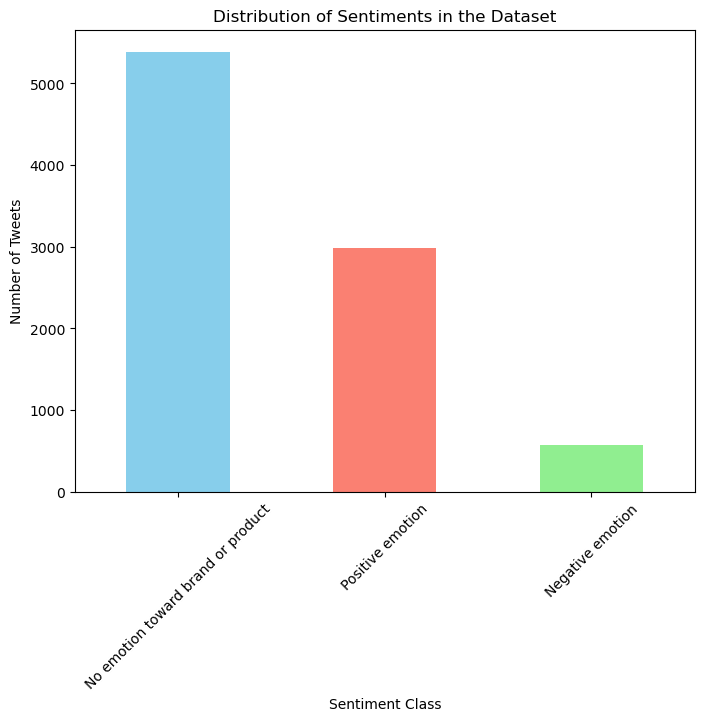

In [60]:
# Plotting the value counts of the three sentiment classes
plt.figure(figsize=(8, 6))
df_multi['sentiment'].value_counts().plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Distribution of Sentiments in the Dataset')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.show()

### comparison of binary models

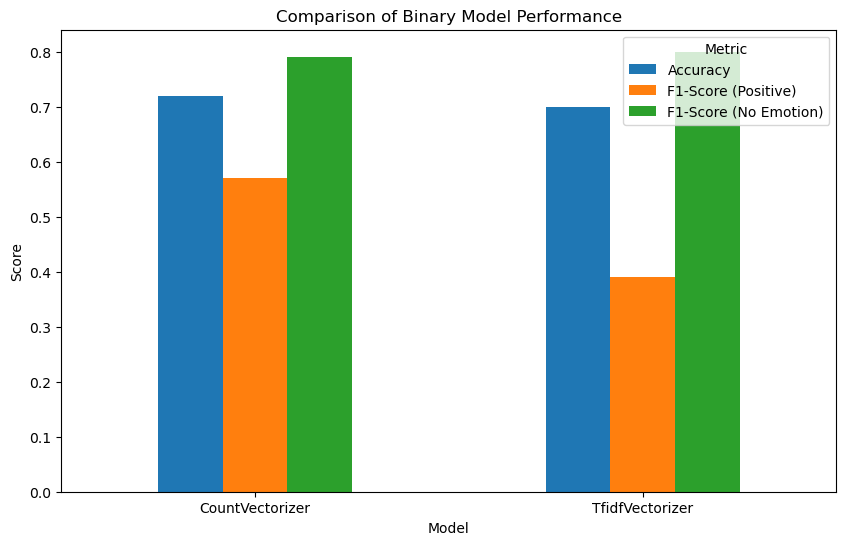

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Data from our previous evaluation reports
data = {
    'Model': ['CountVectorizer', 'TfidfVectorizer'],
    'Accuracy': [0.72, 0.70],
    'F1-Score (Positive)': [0.57, 0.39],
    'F1-Score (No Emotion)': [0.79, 0.80]
}
comparison_df = pd.DataFrame(data)
comparison_df.set_index('Model', inplace=True)

# Plotting the comparison
fig, ax = plt.subplots(figsize=(10, 6))
comparison_df[['Accuracy', 'F1-Score (Positive)', 'F1-Score (No Emotion)']].plot(kind='bar', ax=ax)
ax.set_title('Comparison of Binary Model Performance')
ax.set_ylabel('Score')
ax.tick_params(axis='x', rotation=0)
ax.legend(title='Metric')
plt.show()

#### Interpreting the Results
By comparing the bars, you can see how each model performs on the different metrics.

The CountVectorizer model has a slightly higher Accuracy and a better F1-Score (Positive), indicating that it was a bit more effective at predicting the "positive" sentiment than the TF-IDF model.

The TfidfVectorizer model has a slightly higher F1-Score (No Emotion), suggesting it was more effective at identifying tweets without a strong sentiment.

### Initial sentiment Distribution

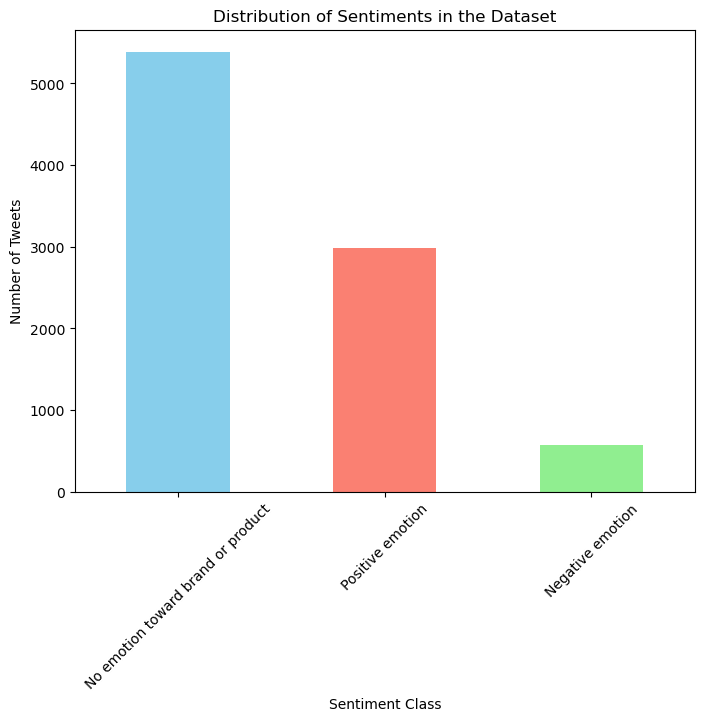

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset to get the full distribution
df_full = pd.read_csv('../data/judge_tweet_product_company.csv', encoding='latin-1')

# Filter for the relevant classes
df_full = df_full[df_full['is_there_an_emotion_directed_at_a_brand_or_product'].isin([
    'Positive emotion',
    'Negative emotion',
    'No emotion toward brand or product'
])]

# Plotting the value counts
plt.figure(figsize=(8, 6))
df_full['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts().plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Distribution of Sentiments in the Dataset')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.show()

### Work cloud for each sentiment

In [64]:
!pip install wordcloud

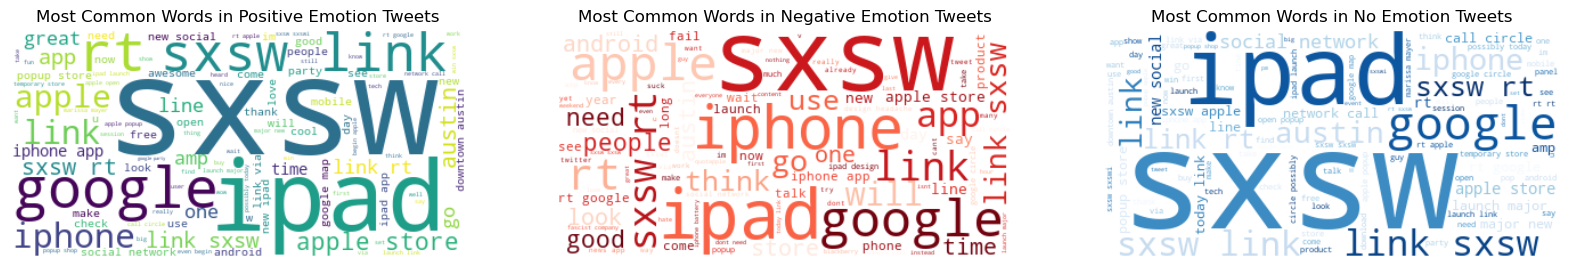

In [65]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all the text for each sentiment category
positive_text = " ".join(review for review in df_multi[df_multi['sentiment'] == 'Positive emotion'].lemmatized_text)
negative_text = " ".join(review for review in df_multi[df_multi['sentiment'] == 'Negative emotion'].lemmatized_text)
no_emotion_text = " ".join(review for review in df_multi[df_multi['sentiment'] == 'No emotion toward brand or product'].lemmatized_text)

# Create and generate a word cloud for each sentiment
wordcloud_positive = WordCloud(background_color="white", max_words=100, colormap='viridis').generate(positive_text)
wordcloud_negative = WordCloud(background_color="white", max_words=100, colormap='Reds').generate(negative_text)
wordcloud_no_emotion = WordCloud(background_color="white", max_words=100, colormap='Blues').generate(no_emotion_text)

# Display the generated images
plt.figure(figsize=(20, 10))

# Positive Word Cloud
plt.subplot(1, 3, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Most Common Words in Positive Emotion Tweets')
plt.axis('off')

# Negative Word Cloud
plt.subplot(1, 3, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Most Common Words in Negative Emotion Tweets')
plt.axis('off')

# No Emotion Word Cloud
plt.subplot(1, 3, 3)
plt.imshow(wordcloud_no_emotion, interpolation='bilinear')
plt.title('Most Common Words in No Emotion Tweets')
plt.axis('off')

plt.show()

### Save the model and vectorizer

In [67]:
import pickle

# Define the file paths where we will save the model and vectorizer
model_filename = 'final_sentiment_model.pkl'
vectorizer_filename = 'final_vectorizer.pkl'

# Save the final multi-class model
with open(model_filename, 'wb') as file:
    pickle.dump(multi_model, file)
    
# Save the final multi-class vectorizer
with open(vectorizer_filename, 'wb') as file:
    pickle.dump(multi_vectorizer, file)

print(f"Model saved to {model_filename}")
print(f"Vectorizer saved to {vectorizer_filename}")

Model saved to final_sentiment_model.pkl
Vectorizer saved to final_vectorizer.pkl
